<a href="https://colab.research.google.com/github/ZhuoquanChen/Data-Science-Projects/blob/main/Chest_Disease_Classification/Chest_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chest Disease Classification**
This project used deep learning technique in healthcare industry and achieved automaticly detecting and classifying to different types of chest diseases such as healthy, covid-19, bacterial pneumonia and viral pneumonia by using chest X-ray images, which can help a doctor to determine a chest disease case in less than one minute. 
- Applied Keras' API to build a convolutional networks
- Applied residual neural network for transfer learning
- Evaluated resNet training model on test data
- Applied activation functions
- Applied confusion metric for precision and recall

##  **> Background**
AI/ML/DL has been revolutionizing in industries of healthcare and medicine, such as medical imagery, drug research and genome development. Also, it has been aproven to be superior in detecting and classifying disease using imagery data. 
For example, skin cancer could be detected more accurate by deep learning than by dermatologists in 2018. 
- Human dermatologists detection is 86.6%
- Deep learning detection is 95%

* Reference: "Computer learns to detect skin cancer more accurate than doctors". The Guardian, 29 May 2018

## **> Problem Statement**
In this case, I am a deep learning consultant that work at a hospital in New York City. Recently, I have been tasked to develop a model by using extensive chest X-ray images to automate the process of detecting and classifying different types of chest disease, as well as reduce the cost and time of detection. The chest diseases were classified as Healthy, Covid-19, Bacterial Pneumonia and Viral Pneumonia.

## **> Data Source**
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

## **> Import General Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

%matplotlib inline

## **> Load Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Specify training data directory

x_ray_directory = '/content/drive/MyDrive/Colab Notebooks/datasets/Data_Scieence_Business_Projects/Chest_Disease_Classification/Dataset/train'

In [5]:
# List the folders in the directory

import os

files = os.listdir(x_ray_directory)
files

['1', '0', '3', '2']

In [6]:
# Use image generator to generate tensor images data and normalize them (1/255)
# Use 20% of the data for cross-validation, 80% for training

from tensorflow.keras.preprocessing.image import ImageDataGenerator  

image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)

In [7]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(directory=x_ray_directory, target_size=(256, 256), 
                                                      class_mode='categorical', batch_size=40, shuffle=True, subset='training')

Found 428 images belonging to 4 classes.


In [8]:
validation_generator = image_generator.flow_from_directory(directory=x_ray_directory, target_size=(256,256), 
                                                           class_mode='categorical', batch_size=40, shuffle=True, 
                                                           subset='validation')

Found 104 images belonging to 4 classes.


In [9]:
# Generate a batch of 40 images and labels

train_images, train_labels = next(train_generator)

In [10]:
train_images.shape # The dimensions should be 4, batch_size, pixels(w:256, h:256), colors(r, g, b)

(40, 256, 256, 3)

In [11]:
train_labels.shape # The dimensions should be 2, batch_size and categorial

(40, 4)

In [12]:
train_labels[:5]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [13]:
# labels Translator 

label_names = {0: 'Covid-19', 1: 'Healthy', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

## **> Visualizing Data**

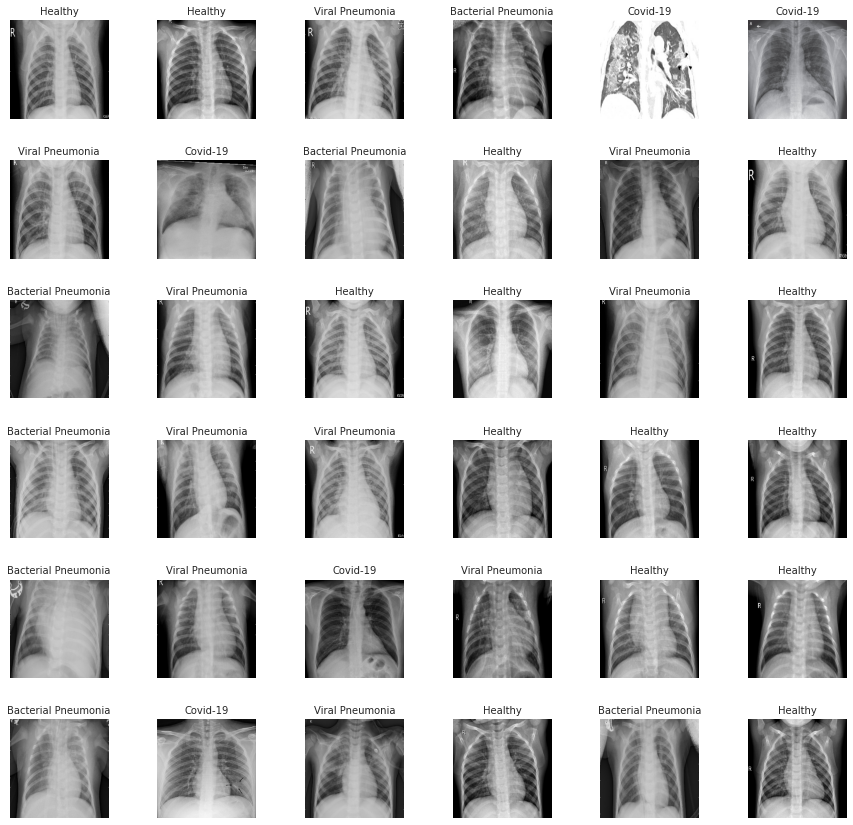

In [14]:
# Create a grid for displaying images

L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize=(15, 15))
axes = axes.ravel() # flatten, 1*256*256*3

for i in np.arange(0, L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])], fontsize=10)
  axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

## **> Applying Convolutional Neural Networks**
**Using Residual Network For Transfer Learning**

In [15]:
import tensorflow as tf

### 1. Import Pre-trained Model With Weights

In [16]:
# Download ResNet50
# ResNet has trained by ImageNet with 11 million images, and it has 11000 categories. So this model has known a lot already.

# PARAMETERS:
# weights: 'imagenet'
# include_top: we don't need it which is represent the classification output. (the original has 11000 categories output)
# input_tensor: the shape of image (pixels, pixels, chanels)

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input

based_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [17]:
based_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

There 23,587,712 parameters in ResNet50 model, which is the total number of parameters need to optimize in a new model.

### 2. Freezing layers in the model
**It means freezing those layers I may not want to change it.**

In [18]:
from tensorflow.keras import layers

for layer in based_model.layers[:-10]: # set up the freezing layers, except the last 10 layers
  layers.trainable = False             # these layers no need to train again, using the original parameters(weights)

### 3. Build And Train a New Model for fitting This Task

In [19]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Add, Dense, Activation, BatchNormalization, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, AveragePooling2D
from tensorflow.keras.models import Model

In [20]:
# Building the fully connected(dense) layers (classification layers) for classification

# 1. add input layer as the head of the fully connected layers, which will start from the output of based_model
fully_connected_layers = based_model.output

# 2. add pooling layer on it
fully_connected_layers = AveragePooling2D(pool_size=(4,4))(fully_connected_layers)

# 3. add flatten layer
fully_connected_layers = Flatten(name='flatten')(fully_connected_layers)

# 4. add dense layer
fully_connected_layers = Dense(256, activation='relu')(fully_connected_layers)

# 5. add dropout layer
fully_connected_layers = Dropout(0.3)(fully_connected_layers)

# These two layers can be more
fully_connected_layers = Dense(256, activation='relu')(fully_connected_layers)
fully_connected_layers = Dropout(0.3)(fully_connected_layers)

# 6. add classification output layer: 4 is categorical, 'relu'->'softmax'
fully_connected_layers = Dense(4, activation='softmax')(fully_connected_layers)

In [21]:
# Combine the based_model with the fully_connected_layers as a new model

new_model = Model(inputs=based_model.input, outputs=fully_connected_layers)

In [22]:
# Compile the new_model

new_model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

In [23]:
# Using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20, verbose=1)

In [24]:
# Save the best model with lower validation loss

from tensorflow.keras.callbacks import ModelCheckpoint
check_pointer = ModelCheckpoint(filepath="weights.hdf5", save_best_only=True) # saving all the weights of this model

In [25]:
# Set up training data and validation data

train_generator = image_generator.flow_from_directory(directory=x_ray_directory, target_size=(256, 256), 
                                                      class_mode='categorical', batch_size=4, shuffle=True, subset='training')

val_generator = image_generator.flow_from_directory(directory=x_ray_directory, target_size=(256, 256), 
                                                      class_mode='categorical', batch_size=4, shuffle=True, subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
# Fit the model, here using fit_generator instead of fit

history = new_model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=50, 
                        callbacks=[early_stopping, check_pointer])

Epoch 1/50
107/107 [==============================] - 510s 5s/step - loss: 1.2986 - accuracy: 0.5462 - val_loss: 7.1896 - val_accuracy: 0.2500
Epoch 2/50
107/107 [==============================] - 413s 4s/step - loss: 0.4007 - accuracy: 0.8577 - val_loss: 45.6834 - val_accuracy: 0.2500
Epoch 3/50
107/107 [==============================] - 420s 4s/step - loss: 0.1994 - accuracy: 0.9560 - val_loss: 9.9164 - val_accuracy: 0.2308
Epoch 4/50
107/107 [==============================] - 420s 4s/step - loss: 0.1829 - accuracy: 0.9440 - val_loss: 15.0669 - val_accuracy: 0.2500
Epoch 5/50
107/107 [==============================] - 420s 4s/step - loss: 0.1281 - accuracy: 0.9490 - val_loss: 18.6409 - val_accuracy: 0.2500
Epoch 6/50
107/107 [==============================] - 420s 4s/step - loss: 0.1688 - accuracy: 0.9431 - val_loss: 8.9748 - val_accuracy: 0.2596
Epoch 7/50
107/107 [==============================] - 421s 4s/step - loss: 0.1526 - accuracy: 0.9635 - val_loss: 16.9124 - val_accuracy: 0.

## **> Evaluate The Training Model**

In [ ]:
list(history.history.keys())

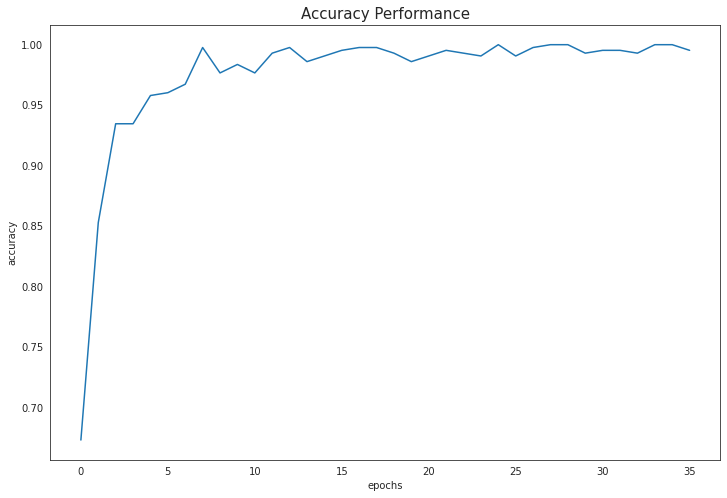

In [39]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'])
plt.title('Accuracy Performance', fontdict={'fontsize': 15})
plt.xlabel('epochs')
plt.ylabel('accuracy');

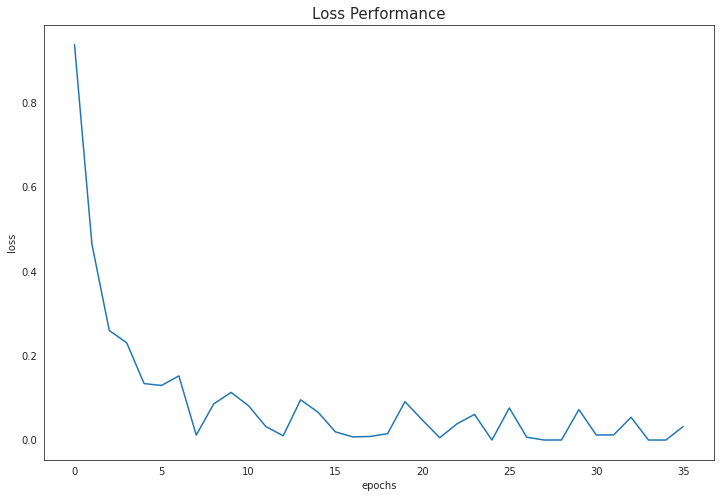

In [40]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.title('Loss Performance', fontdict={'fontsize': 15})
plt.xlabel('epochs')
plt.ylabel('loss');

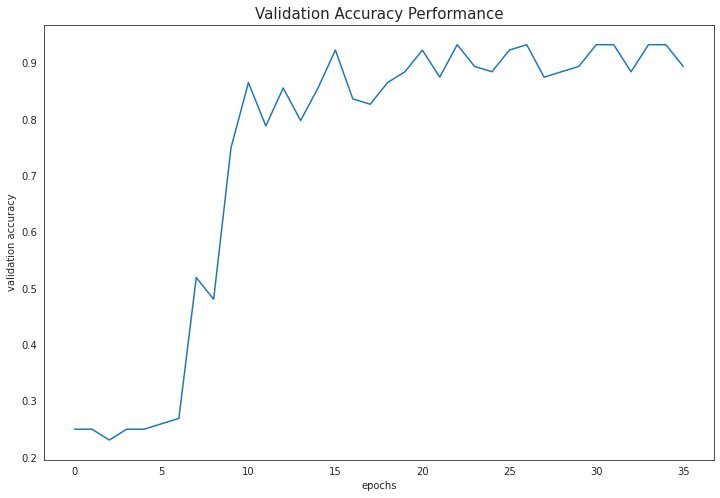

In [41]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy Performance', fontdict={'fontsize': 15})
plt.xlabel('epochs')
plt.ylabel('validation accuracy');

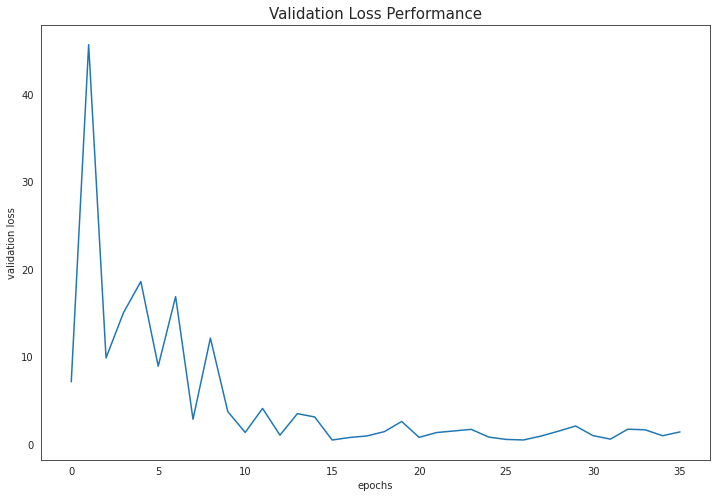

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['val_loss'])
plt.title('Validation Loss Performance', fontdict={'fontsize': 15})
plt.xlabel('epochs')
plt.ylabel('validation loss');

## **> Prediction**

In [43]:
# Process test data

test_directory = '/content/drive/MyDrive/Colab Notebooks/datasets/Data_Scieence_Business_Projects/Chest_Disease_Classification/Dataset/Test'

# Normalizing images scale
test_images_generator = ImageDataGenerator(rescale=1/255)

test_generator = test_images_generator.flow_from_directory(directory=test_directory, target_size=(256, 256), 
                                                           class_mode='categorical', batch_size=40, shuffle=True, subset='training')

Found 40 images belonging to 4 classes.


In [44]:
# Evaluating model in test data

evaluation = new_model.evaluate(test_generator, steps=test_generator.n//4, verbose=1)

# evaluation output will be [loss, accuracy]
print('** The Test Accuracy: {} **'.format(evaluation[1]))

10/10 [==============================] - 9s 1ms/step - loss: 4.4853 - accuracy: 0.8000
** The Test Accuracy: 0.800000011920929 **


### Test visualization

In [45]:
import cv2

prediction = []
ground_true = []
test_images = []

for i in range(len(os.listdir(test_directory))-1):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    img= cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img,(256, 256))
    test_images.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = new_model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    ground_true.append(i)

In [46]:
from sklearn.metrics import accuracy_score

score = accuracy_score(ground_true, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.8


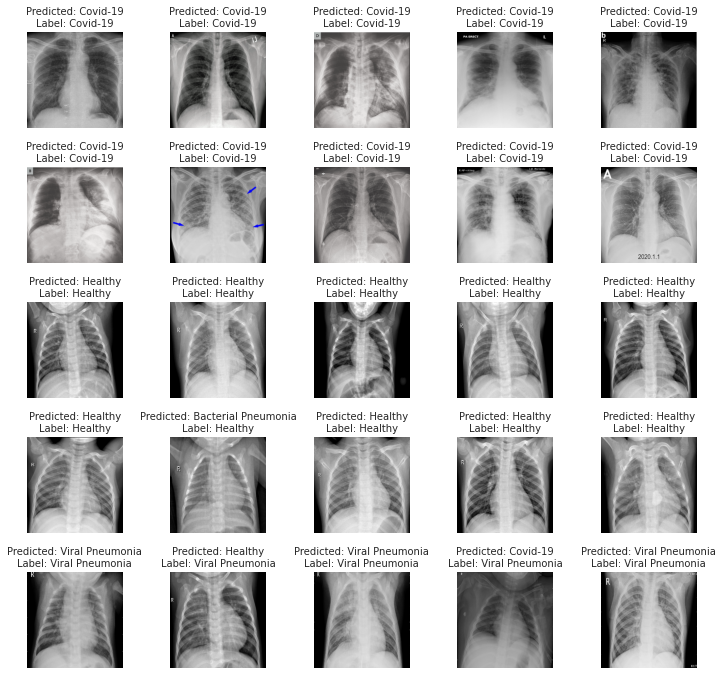

In [47]:
# Create a grid for displaying images

L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel() # flatten, 1*256*256*3

for i in np.arange(0, L*W):
  axes[i].imshow(test_images[i])
  axes[i].set_title('Predicted: {}\nLabel: {}'.format(str(label_names[prediction[i]]), str(label_names[ground_true[i]])), fontsize=10)
  axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

## **> Evaluation Metric** - Confusion Matrix

In [48]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(np.asarray(ground_true), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.64      0.90      0.75        10
           2       1.00      0.50      0.67        10
           3       0.80      0.80      0.80        10

    accuracy                           0.80        40
   macro avg       0.84      0.80      0.79        40
weighted avg       0.84      0.80      0.79        40



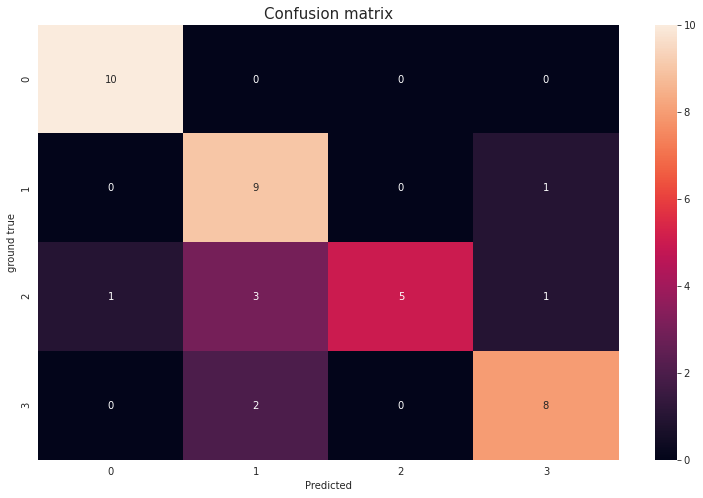

In [49]:
cm = confusion_matrix(np.asarray(ground_true), np.asarray(prediction))
plt.figure(figsize=(13, 8))
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('ground true')
plt.title('Confusion matrix', fontdict={'fontsize': 15});